# Prediction of energy market prices (part 1)

You are given meteorological and market data for part of 2025. [Meteorological data file](https://github.com/jkved/enerheads-quant-challenge/blob/main/data/weather_location_Vilnius.csv)(s) contains day-ahead and intraday forecasts for meteorological variables for a single location. The data description is available on [OpenMeteo](https://open-meteo.com/en/docs) docs and the timezone here is in UTC. This will contain some of your predictors values. Day ahead value (with suffix `previous_day1`) is known 24 hours before delivery time, intraday (no suffix column) is around 1 hour before or at delivery time. Market data (predictors and target values) is given in file [market data file](https://github.com/jkved/enerheads-quant-challenge/blob/main/data/market_data.csv), the data is also publicly available on [Baltic transparency dashboard](https://baltic.transparency-dashboard.eu/). Here index is in UTC timezone and two columns here are considered our target variables:
- `10YLT-1001A0008Q_DA_eurmwh` - this is Nord Pool day-ahead auction cleared prices (EUR/MWh). It is resolved day before delivery day (day-ahead), i.e. today at 10:00 UTC we find out prices for tommorrow CET day (22:00 UTC today -> 22:00 UTC tommorrow). Only weather data with `previous_day1` suffix is available at inference time
- `LT_up_sa_cbmp` or `LT_down_sa_cbmp` - this is mFRR activation prices. Generally only up or down activations take place at the same time so price is duplicated in these columns. It is resolved at delivery time (intraday). All weather data and Nord Pool prices are available at inference time but all other market data is visible with a 30 minute lag, i.e. for an mFRR activation price @ 11:00, all other market data is visible only up to (not including) 10:30.

Complete the following tasks:

1. Create Nord Pool prices forecasting model in day-ahead setting.
2. Create mFRR prices forecasting model in intraday setting
3. Implement certain evaluation metrics for prices:
   - you wish to accurately guess times when smallest and largest prices of the day take shape.
   - you wish to know how many instances there are with spreads between smallest and largest prices being bigger than X (say, 200 EUR/MWh).
4. Choose a collection of 2-3 plots to visualize the performance of both models.

    


# Table of Contents


# Introduction

# Importing the Data

In [1]:
from functools import reduce
import glob
import os

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import warnings

from utils import get_time_of_day, get_season

In [2]:
warnings.filterwarnings("ignore")

In [3]:
market_df = pd.read_csv("data/market_data.csv", index_col=0)
market_df.index = pd.to_datetime(market_df.index, utc=True)
print(market_df.shape)
market_df.head()

(11424, 100)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


In [4]:
market_df.tail()

,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-06-27 22:45:00+00:00,0.0,7.996,0.0,10.580,0.0,9.07,20.70,128.30,-149.55,10.0,...,0.0,-1.00,0.0,-1,-1.0,-1.0,-111.89,-119.82,-113.94,9.98
2025-06-27 23:00:00+00:00,0.0,4.968,0.0,10.286,0.0,5.92,20.66,100.00,-149.47,10.0,...,0.0,-9.70,0.0,-1,-1.0,-1.0,-73.98,-13.40,-30.97,9.98
2025-06-27 23:15:00+00:00,0.0,3.718,0.0,9.045,0.0,0.70,19.68,19.68,-149.03,0.0,...,0.0,-9.70,0.0,-1,-1.0,-1.0,-13.41,3.70,43.23,9.98
2025-06-27 23:30:00+00:00,0.0,4.742,0.0,9.524,0.0,4.92,19.21,19.21,-149.73,0.0,...,0.0,-14.94,0.0,-1,-1.0,-1.0,-26.88,-2.27,28.08,9.98
2025-06-27 23:45:00+00:00,0.0,7.403,0.0,10.516,0.0,11.77,19.49,19.49,-149.15,0.0,...,0.0,-9.70,0.0,-1,-1.0,-1.0,-136.13,-117.38,-128.90,9.98


In [5]:
files = glob.glob("data/weather_location_*.csv")
dfs = []

for file in files:
    city = os.path.splitext(os.path.basename(file))[0].replace("weather_location_", "")
    df = pd.read_csv(file, index_col=0)
    df = df.rename(columns={col: f"{col}_{city}" for col in df.columns})
    
    dfs.append(df)

weather_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
weather_df.index = pd.to_datetime(weather_df.index, utc=True)
print(weather_df.shape)
weather_df.head()

(2856, 140)


,wind_speed_80m_Alytus,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_Alytus,cloud_cover_previous_day1_Alytus,...,direct_radiation_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,13.333627,13.684512,125.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0
2025-03-01 01:00:00+00:00,12.280973,14.737166,123.0,99.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0
2025-03-01 02:00:00+00:00,13.333627,12.631857,118.0,101.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.8735,1.8235,89.0,90.0
2025-03-01 03:00:00+00:00,11.228318,9.473893,130.0,102.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.7735,1.8235,89.0,89.0
2025-03-01 04:00:00+00:00,9.123008,7.368583,152.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9235,1.7235,90.0,90.0


In [6]:
weather_df.tail()

,wind_speed_80m_Alytus,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_Alytus,cloud_cover_previous_day1_Alytus,...,direct_radiation_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-06-27 19:00:00+00:00,29.474333,29.123451,290.0,285.0,0.0,0.0,3.0,1.0,100.0,100.0,...,0.0,0.0,3.0,1.0,100.0,100.0,16.5235,16.4235,88.0,90.0
2025-06-27 20:00:00+00:00,30.526989,32.983180,283.0,286.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,16.3735,16.1735,88.0,90.0
2025-06-27 21:00:00+00:00,37.193806,36.842920,285.0,288.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,16.1735,16.0235,89.0,88.0
2025-06-27 22:00:00+00:00,32.632298,32.632298,284.0,282.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,16.1235,15.7235,89.0,91.0
2025-06-27 23:00:00+00:00,25.614600,28.421680,279.0,276.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,15.8235,15.6235,90.0,92.0


We have data from 2025-03-01  to 2025-06-27, which is consistant in both data frames and in weather data by city. Since each task require a different approach for the optimization I will prepare the data frames for that particucal task. Now lets just quicly look at how many `NaN`s or diplicated values we have.

In [7]:
weather_df.isna().sum().sum()

0

In [8]:
market_df.isna().sum()[market_df.isna().sum() != 0].sort_values(ascending=False).head(40)

LV_up_da_cbmp                10194
LV_down_da_cbmp              10194
LV_procur_afrr_up_price       9718
LV_procur_afrr_down_price     9718
EE_procur_afrr_down_price     9694
EE_procur_afrr_up_price       9694
LT_procur_afrr_up_price       9670
LT_procur_afrr_down_price     9670
EE_procur_afrr_down_vol       9215
EE_procur_afrr_up_vol         9215
LV_procur_afrr_down_vol       9215
LT_procur_afrr_up_vol         9215
LT_procur_afrr_down_vol       9215
LV_procur_afrr_up_vol         9215
LV_procur_mfrr_down_price     8828
LV_procur_mfrr_up_price       8828
LV_procur_mfrr_up_vol         8577
LV_procur_mfrr_down_vol       8577
EE_procur_FCR_price           8568
LT_procur_FCR_price           8568
LT_procur_mfrr_down_vol       8568
LT_procur_mfrr_up_vol         8568
LV_procur_FCR_vol             8568
EE_procur_mfrr_down_vol       8568
EE_procur_mfrr_up_vol         8568
EE_procur_FCR_vol             8568
LT_procur_mfrr_down_price     8568
LT_procur_mfrr_up_price       8568
LT_procur_FCR_vol   

Let's leave only the columns that have more than 50% of values that are not `NaN`

In [9]:
percent_missing = 0.5
market_df_filtered = market_df.loc[:, market_df.isnull().mean() < percent_missing]
print(market_df_filtered.shape)
market_df_filtered.head()

(11424, 68)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


# Nord Pool prices forecasting model in day-ahead setting

Since we will only have features availible with `*_previous_day1_*`  lets create a data frame for that. For the market data I will assume that target and predictive values, are aligned correctly but if not we can just move the data to upcomming day (data from 2025-03-01 would go to 2023-03-02), and the issue will be solved.

In [10]:
weather_features = [col for col in weather_df.columns if "_previous_day1_" in col]
weather_prev_day_df = weather_df[weather_features]
print(weather_prev_day_df.shape)
weather_prev_day_df.head()

(2856, 70)


,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_previous_day1_Alytus,temperature_2m_previous_day1_Alytus,relative_humidity_2m_previous_day1_Alytus,wind_speed_80m_previous_day1_Kaunas,wind_direction_80m_previous_day1_Kaunas,direct_radiation_previous_day1_Kaunas,...,cloud_cover_previous_day1_Utena,temperature_2m_previous_day1_Utena,relative_humidity_2m_previous_day1_Utena,wind_speed_80m_previous_day1_Vilnius,wind_direction_80m_previous_day1_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,13.684512,87.0,0.0,0.0,100.0,0.8285,96.0,16.140705,67.0,0.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 01:00:00+00:00,14.737166,99.0,0.0,0.0,100.0,0.7285,97.0,15.088053,66.0,0.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 02:00:00+00:00,12.631857,101.0,0.0,0.0,100.0,0.7285,96.0,14.386281,60.0,0.0,...,100.0,0.848,98.0,11.930088,87.0,0.0,0.0,100.0,1.8235,90.0
2025-03-01 03:00:00+00:00,9.473893,102.0,0.0,0.0,100.0,0.6285,97.0,14.386281,49.0,0.0,...,100.0,0.798,98.0,10.526547,84.0,0.0,0.0,100.0,1.8235,89.0
2025-03-01 04:00:00+00:00,7.368583,87.0,0.0,0.0,100.0,0.5285,97.0,15.438937,40.0,0.0,...,100.0,0.748,98.0,9.473893,70.0,0.0,0.0,100.0,1.7235,90.0


In [11]:
weather_upsampled = weather_prev_day_df.loc[weather_prev_day_df.index.repeat(4)].copy()
weather_upsampled.index = market_df_filtered.index
merged_df = pd.concat([market_df_filtered, weather_upsampled], axis=1)

print(merged_df.shape)
merged_df.head(8)

(11424, 138)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,cloud_cover_previous_day1_Utena,temperature_2m_previous_day1_Utena,relative_humidity_2m_previous_day1_Utena,wind_speed_80m_previous_day1_Vilnius,wind_direction_80m_previous_day1_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 01:15:00+00:00,3.061,0.000,3.315,0.0,0.00,2.38,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 01:30:00+00:00,2.250,0.000,3.379,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 01:45:00+00:00,0.517,0.684,1.854,0.0,0.00,2.42,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0


Let's create some new features that might influence the usage of electricity. 

In [12]:
df = merged_df.copy()

df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["time_of_day"] = df["hour"].apply(get_time_of_day)
df["season"] = df["month"].apply(get_season)
df["time_of_day"] = df["time_of_day"].astype("category")
df["season"] = df["season"].astype("category")

print(df.shape)
df.head()

(11424, 143)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,direct_radiation_previous_day1_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_previous_day1_Vilnius,hour,dayofweek,month,time_of_day,season
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.7735,91.0,1,5,3,night,spring


Lets define targets and training features for the model, and split the data into testing and training sets.

In [13]:
targets = ["10YLT-1001A0008Q_DA_eurmwh", "LT_up_sa_cbmp", "LT_down_sa_cbmp"]
features =  [col for col in df.columns if col not in targets]

# It is sorted by time but better safe than sorry
df = df.sort_index()

split_idx = int(len(df) * 0.8)
X_train = df[features].iloc[:split_idx]
y_train = df[targets[0]].iloc[:split_idx]
X_test = df[features].iloc[split_idx:]
y_test = df[targets[0]].iloc[split_idx:]

## XGBoost

In [14]:
model_xgb = XGBRegressor(
    random_state=9,
    enable_categorical=True,
    tree_method="hist",
    n_jobs=-1
)

param_grid_xgb = {
    "n_estimators": [400, 450, 500],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.025, 0.05],
    "subsample": [0.8, 0.9, 1],
    "colsample_bytree": [0.4, 0.5, 0.6,],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,  
    scoring=mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_train, y_train)

print("Best parameters:", grid_search_xgb.best_params_)
print("Best MAE CV:", -grid_search_xgb.best_score_)
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("Test MAE:", round(mae_test_xgb, 4))

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 450, 'subsample': 0.9}
Best MAE CV: 27.400302564858624


NameError: name 'mae_test' is not defined

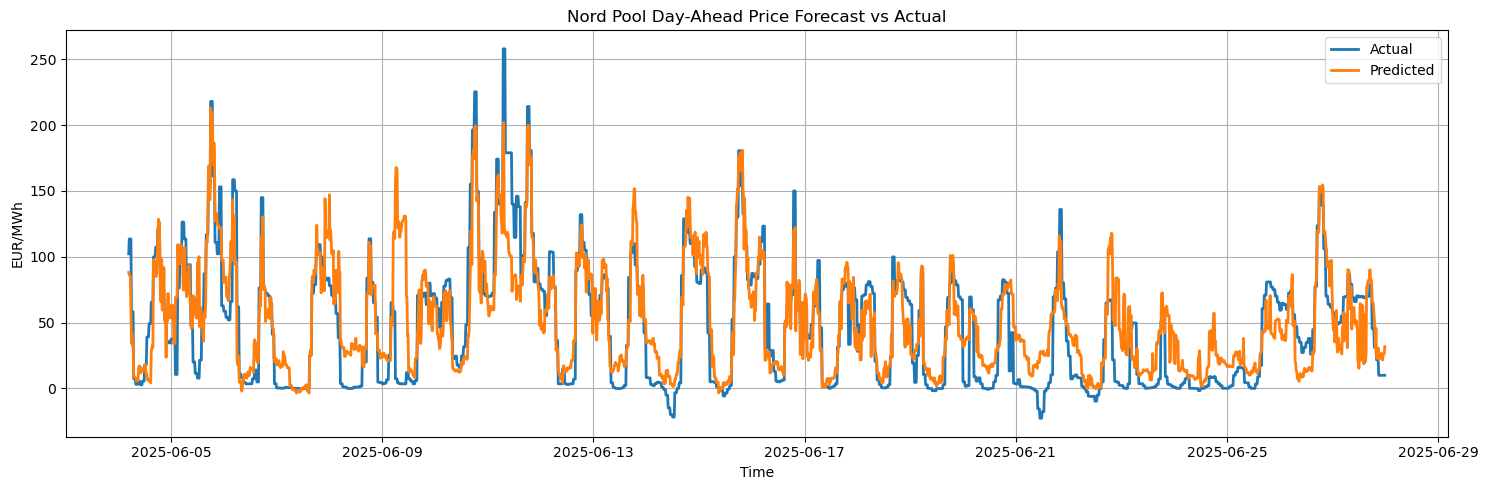

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_xgb, label="Predicted", linewidth=2)
plt.title("Nord Pool Day-Ahead Price Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 features XGBoost:
LT_mfrr_SA_down_max_bid                    0.129417
EE_mfrr_SA_down_max_bid                    0.086028
EE_mfrr_SA_up_min_bid                      0.049332
LV_mfrr_SA_down_max_bid                    0.039812
diffuse_radiation_previous_day1_Telsiai    0.036962
LT_mfrr_SA_down_min_bid                    0.034500
LT_mfrr_SA_up_max_bid                      0.031344
month                                      0.029160
diffuse_radiation_previous_day1_Taurage    0.027216
diffuse_radiation_previous_day1_Kaunas     0.026205
dtype: float32


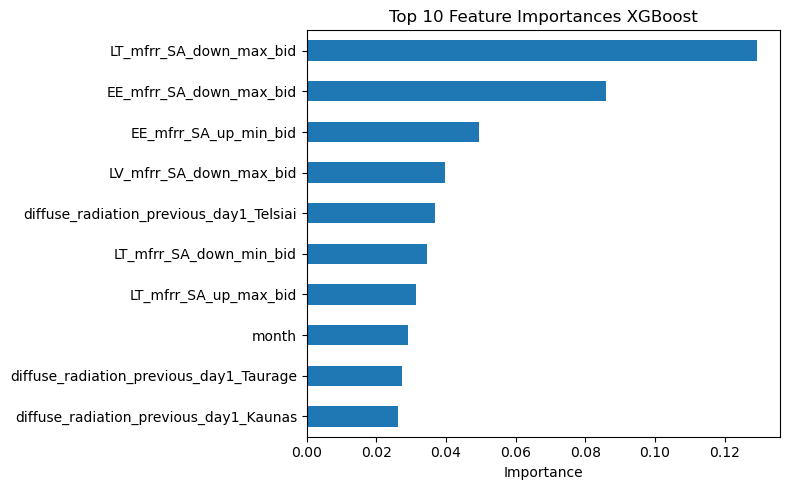

In [17]:
best_model_xgb = grid_search_xgb.best_estimator_

if hasattr(best_model_xgb, "feature_names_in_"):
    feature_names = best_model_xgb.feature_names_in_
else:
    feature_names = X_train.columns

importances_xgb = pd.Series(
    best_model_xgb.feature_importances_, index=feature_names
).sort_values(ascending=False)

print("Top 10 features XGBoost:")
print(importances_xgb.head(10))

importances_xgb.head(10).plot(
    kind="barh", figsize=(8, 5), title="Top 10 Feature Importances XGBoost"
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

I would say the model works well forcating to the near future but the further to the future we go the model performance decreases. But I think that is not an issue since  our goal is to predict to the near future. 

## LightGBM

In [ ]:
model_lgbm = LGBMRegressor(
    random_state=9,
    n_jobs=-1
)

param_grid_lgbm = {
    "n_estimators": [450, 500, 550, 600],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.025, 0.05],
    "subsample": [0.8, 0.9, 1],
    "colsample_bytree": [0.5, 0.6, 0.7],
}


grid_search_lgbm = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid_lgbm,
    scoring=mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_lgbm.fit(X_train, y_train)

print("Best parameters (LGBM):", grid_search_lgbm.best_params_)
print("Best MAE CV (LGBM):", -grid_search_lgbm.best_score_)

y_pred_lgbm = grid_search_lgbm.best_estimator_.predict(X_test)
mae_test_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print("Test MAE (LGBM):", round(mae_test_lgbm, 4))

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_lgbm, label="Predicted", linewidth=2)
plt.title("Nord Pool Day-Ahead Price Forecast vs Actual LGBMRegressor")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
best_model_lgb = grid_lgb.best_estimator_

if hasattr(best_model_lgb, "feature_names_in_"):
    feature_names = best_model_lgb.feature_names_in_
else:
    feature_names = X_train.columns

importances_lgb = pd.Series(
    best_model_lgb.feature_importances_, index=feature_names
).sort_values(ascending=False)

print("Top 10 features LightGBM:")
print(importances_lgb.head(10))

importances_lgb.head(10).plot(
    kind="barh", figsize=(8, 5), title="Top 10 Feature Importances LightGBM"
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## CatBoost

In [ ]:
model_cat = CatBoostRegressor(
    random_state=9,
    silent=True,
    thread_count=-1
)

param_grid_cat = {
    "iterations": [450, 500, 600],
    "depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.025, 0.05],
    "subsample": [0.8, 0.9, 1],
    "colsample_bylevel": [0.5, 0.6, 0.7],
}

grid_search_cat = GridSearchCV(
    estimator=model_cat,
    param_grid=param_grid_cat,
    scoring=mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_cat.fit(X_train, y_train)

print("Best parameters (CatBoost):", grid_search_cat.best_params_)
print("Best MAE CV (CatBoost):", -grid_search_cat.best_score_)

y_pred_cat = grid_search_cat.best_estimator_.predict(X_test)
mae_test_cat = mean_absolute_error(y_test, y_pred_cat)

print("Test MAE (CatBoost):", round(mae_test_cat, 4))

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_cat, label="Predicted", linewidth=2)
plt.title("Nord Pool Day-Ahead Price Forecast vs Actual CatBoostRegressor")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
best_model_cat = grid_cat.best_estimator_

feature_names = X_train.columns

importances_cat = pd.Series(
    best_model_cat.get_feature_importance(), index=feature_names
).sort_values(ascending=False)

print("Top 10 features CatBoost:")
print(importances_cat.head(10))

importances_cat.head(10).plot(
    kind="barh", figsize=(8, 5), title="Top 10 Feature Importances CatBoost"
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Suggestions for Improvements
use wheather data from Latvia and Estonia